In [254]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

In [255]:
def get_score(valid_y_exp, pred):
    return mean_absolute_error(pred, valid_y_exp)

In [260]:
path = "Dataset/AAl_G_Weather_SkewFix_19des-22mar.csv"

df_data = pd.read_csv(path)

In [261]:
df_data['year'] = pd.to_datetime(df_data['Recorded']).dt.year
df_data['Weekday'] = pd.to_datetime(df_data['Recorded']).dt.weekday
df_data['Hour'] = pd.to_datetime(df_data['Recorded']).dt.hour
df_data['Month'] = pd.to_datetime(df_data['Recorded']).dt.month
df_data['Day'] = pd.to_datetime(df_data['Recorded']).dt.day

In [258]:
# df_data = df_data.drop(columns=["wdir_cardinal","Recorded","SO2","CO",'heat_index', 'rh', 'pressure', 'wdir', 'wspd', 'Weekday',
#        'Hour', 'Month', 'Day', "Year"])

In [241]:
df_data = df_data.drop(columns=["wdir_cardinal","Recorded","SO2","CO","Month", "Day", "pressure"])

In [263]:
df_data.columns

Index(['NO2', 'NOx', 'SO2', 'heat_index', 'rh', 'pressure', 'wdir', 'wspd',
       'year', 'Weekday', 'Hour', 'Month', 'Day'],
      dtype='object')

In [264]:
train_Df = df_data[0:35520]
train_Data = train_Df[0:28416]
val_df = train_Df[28416:]

In [265]:
X_train = train_Data[0:-1].copy()
Y_train = train_Data[["NO2","NOx"]].copy()
Y_train = Y_train[1:]

In [266]:
X_val = val_df[0:-1].copy()
Y_val = val_df[["NO2","NOx"]].copy()
Y_val = Y_val[1:]

In [267]:
Xscaler = StandardScaler()
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = StandardScaler()
Yscaler.fit(Y_train)
scaled_y_train = Yscaler.transform(Y_train)

In [268]:
X_val_scaler = StandardScaler() # scale so that all the X data will range from 0 to 1
X_val_scaler.fit(X_val)
scaled_X_val = X_val_scaler.transform(X_val)
Y_val_scaler = StandardScaler()
Y_val_scaler.fit(Y_val)
scaled_y_val = Y_val_scaler.transform(Y_val)

In [271]:
n_input = 48 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 256 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
valgenerator = TimeseriesGenerator(scaled_X_val,scaled_y_val,length=n_input, batch_size=b_size)

In [270]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min')

model = Sequential()
#model.add(Embedding(input_dim=48,output_dim=48))
model.add(LSTM(12,activation='tanh', input_shape=(n_input, n_features)))
# model.add(Dropout(0.1))
# model.add(Dense(30, activation='tanh'))
# model.add(Dropout(0.3))
model.add(Dense(2))
#model.add(tf.keras.layers.Reshape([48, 3]))
model.compile(loss='mae',optimizer='adam')


#model.fit(generator,epochs=5)
history = model.fit(generator, epochs=35, shuffle=True,
                        validation_data=(valgenerator),
                        callbacks=[early_stopping],
                        verbose=2)

model.summary()

#plot model accuracy
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

#plot feature importance
columnsTitles=train_Data.columns.to_list()
results = []
print(' Computing LSTM Feature importance...')
feature_preds_scale = model.predict(valgenerator, verbose = 0).squeeze()
feature_preds = Y_val_scaler.inverse_transform(feature_preds_scale)
baseline_mae = np.mean(np.abs(feature_preds - Y_val[48:].values))
results.append({'feature': 'BASELINE', 'mae': baseline_mae})

for i in range(len(columnsTitles)):
    save_col = scaled_X_val[:,i].copy()
    np.random.shuffle(scaled_X_val[:,i])
    feature_preds_scale = model.predict(valgenerator, verbose = 0).squeeze()
    feature_preds = Y_val_scaler.inverse_transform(feature_preds_scale)
    mae = np.mean(np.abs(feature_preds - Y_val[48:].values))
    results.append({'feature': columnsTitles[i], 'mae': mae})
    
    scaled_X_val[:,i] = save_col

print()
width = [0.2]
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(5,5))
plt.barh(np.arange(len(columnsTitles)+1),df.mae, width)
plt.yticks(np.arange(len(columnsTitles)+1),df.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,len(columnsTitles)+1))
plt.plot([baseline_mae,baseline_mae],[-1,len(columnsTitles)+1], '--', color='orange',
                    label=f'Baseline \nMAE={baseline_mae:.3f}')
plt.xlabel('MAE with feature permuted',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()

In [219]:

prediction_scale = model.predict(valgenerator)
prediction = Y_val_scaler.inverse_transform(prediction_scale)
score = get_score(prediction,Y_val[48:].values)
score_scale = get_score(prediction_scale,scaled_y_val[48:])
print("val_loss Scaled:",score_scale)
print("val_loss normal:",score)


val_loss Scaled: 0.3017333934760962
val_loss normal: 6.570150595732451


In [273]:
real_df = df_data[35520: -6]
X_test = real_df.copy()
scaled_X_test = Xscaler.transform(X_test)
nplen = (X_test.shape[0],3)
npzeros = np.zeros(nplen)

In [274]:
test_generator = TimeseriesGenerator(scaled_X_test, npzeros, length=n_input, batch_size=b_size)

In [275]:
y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)

In [283]:
NO2_pred = [i[0] for i in y_pred]
NOx_pred = [i[1] for i in y_pred]

In [ ]:
predictionsDf = pd.DataFrame({"Pred_NO2":NO2_pred,"Pred_NOx":NOx_pred})
predictionsDf = predictionsDf.round(2)
predictionsDf.to_csv("LSTM/AAl_G_Prediction.csv",index=False)

In [281]:
NO2_real =real_df["NO2"].values
NOx_real =real_df["NOx"].values

In [ ]:
realDF = pd.DataFrame({"Real_NO2":NO2_real,"Real_NOx":NOx_real})
realDF.to_csv("LSTM/AAl_G_Real.csv",index=False)

In [280]:
scoreNO2 = get_score(NO2_real[48:],NO2_pred)
scoreNOx = get_score(NOx_real[48:],NOx_pred)
average = (scoreNO2 + scoreNOx) / 2
print('NOx score:', scoreNOx, '\n' 'NO2 score:', scoreNO2, '\n' 'Average MAE:', average)

3.2478426856012557

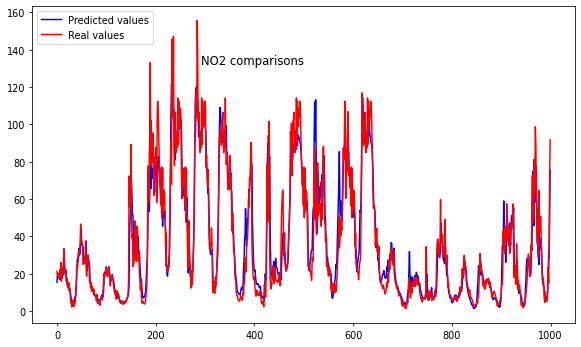

In [284]:

plt.figure(num=None, dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(NO2_pred[0:500], "-b", label="Predicted values")
plt.plot(NO2_real[48:548], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NO2 comparisons', x=0.5, y=0.8, loc='right')
plt.show()

In [ ]:
plt.figure(num=None, dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(NOx_pred[0:500], "-b", label="Predicted values")
plt.plot(NOx_real[48:548], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NOx comparisons', x=0.5, y=0.8, loc='right')
plt.show()